# 1. Import Modules

In [4]:
import requests
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import datetime
from dateutil.relativedelta import relativedelta
import datetime
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import GridSearchCV

# 2. Retrieve and Read Data

In [5]:
#Add API KEY
#url = 'https://www.alphavantage.co/query?function=COFFEE&interval=monthly&datatype=csv&apikey=  ****   '
#
#df = pd.read_csv(url)

In [6]:
df =pd.read_csv('coffee', index_col = 'Unnamed: 0')

# 3. EDA

In [7]:
print(df)

      timestamp             value
0    2023-03-01  222.663913043478
1    2023-02-01           229.506
2    2023-01-01            206.76
3    2022-12-01  210.388636363636
4    2022-11-01  213.718181818182
..          ...               ...
514  1980-05-01                 .
515  1980-04-01                 .
516  1980-03-01                 .
517  1980-02-01                 .
518  1980-01-01                 .

[519 rows x 2 columns]


Two columns, timestamp and value. Timestamp is from 1980-01-01 - 2023-02-01 in 1 month increments. 

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  519 non-null    int64 
 1   timestamp   519 non-null    object
 2   value       519 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.3+ KB
None


both stored as object type, 519 entries

In [5]:
print(df.value.describe())

count     519
unique    400
top         .
freq      120
Name: value, dtype: object


Appears to be 120 values stored as '.'

In [6]:
df= df.rename(columns={'timestamp':'date'})

In [7]:
print(df.date.duplicated().value_counts())

False    519
Name: date, dtype: int64


No dates are duplicated

In [8]:
df = df.drop(df.columns[0], axis=1)
df = df.set_index('date')
pd.to_datetime(df.index)
df.sort_index(ascending=True, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519 entries, 1980-01-01 to 2023-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   value   519 non-null    object
dtypes: object(1)
memory usage: 8.1+ KB


Set index to date, and sort ascending


In [10]:
print(df.head())

           value
date            
1980-01-01     .
1980-02-01     .
1980-03-01     .
1980-04-01     .
1980-05-01     .


In [11]:
df.value.replace('.', np.nan, inplace=True)
df.value = df.value.astype('float')

Replace '.' with null values, change the value type from object to flaot

In [12]:
print(df[df.value.isnull()])

            value
date             
1980-01-01    NaN
1980-02-01    NaN
1980-03-01    NaN
1980-04-01    NaN
1980-05-01    NaN
...           ...
1989-08-01    NaN
1989-09-01    NaN
1989-10-01    NaN
1989-11-01    NaN
1989-12-01    NaN

[120 rows x 1 columns]


In [13]:
df.dropna(inplace=True)

Dropping null values, as they are the oldest entries. Depending on the analysis we will want to weight toward newer entries 

In [14]:
print(df.head())

                value
date                 
1990-01-01  75.829987
1990-02-01  84.010010
1990-03-01  93.959991
1990-04-01  93.730011
1990-05-01  92.019989


In [15]:
print(df.value.describe())

count    399.000000
mean     136.677453
std       55.900913
min       50.830000
25%       91.454775
50%      129.723500
75%      165.888886
max      300.477143
Name: value, dtype: float64


Quick overview of some summary statistics. 

# 4. Visualise

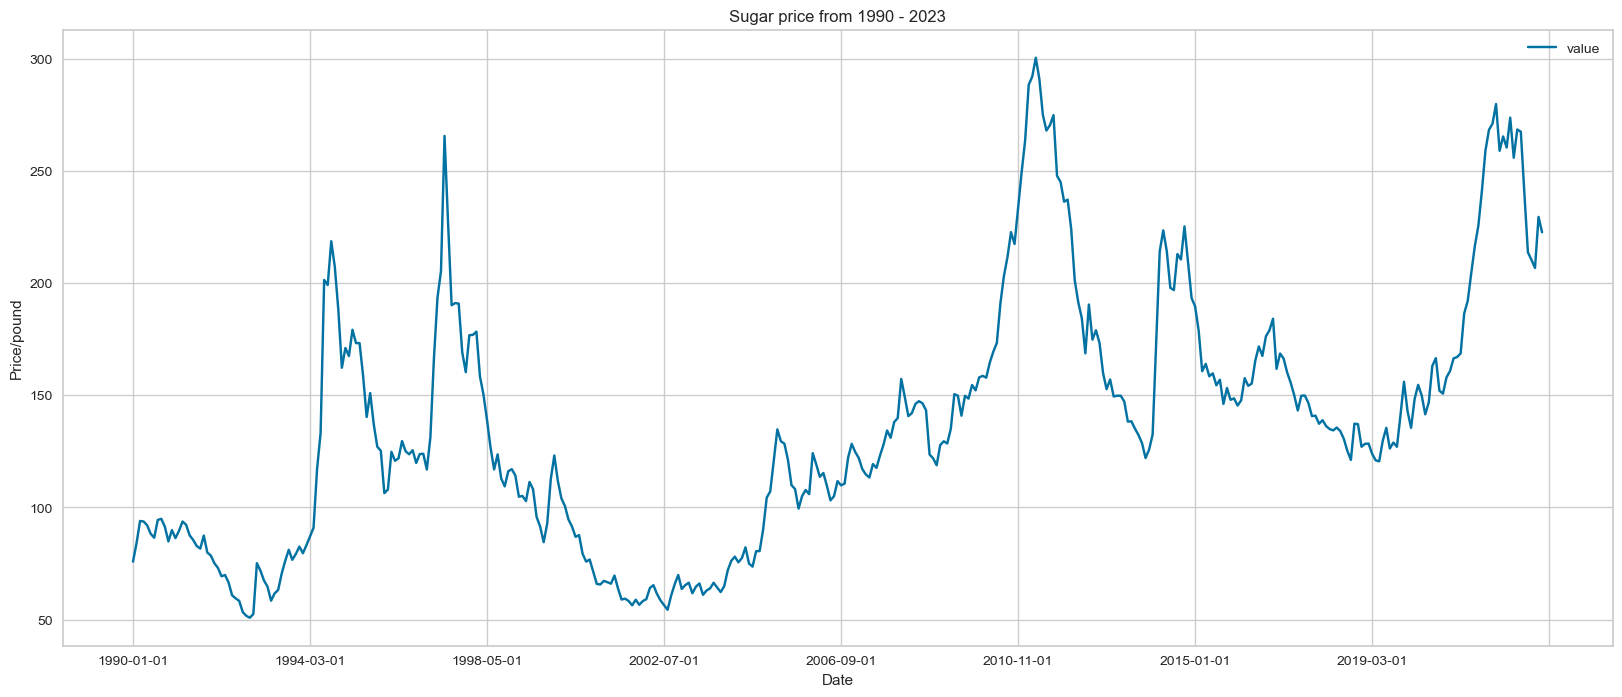

In [16]:
df.plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price from 1990 - 2023')
plt.show()

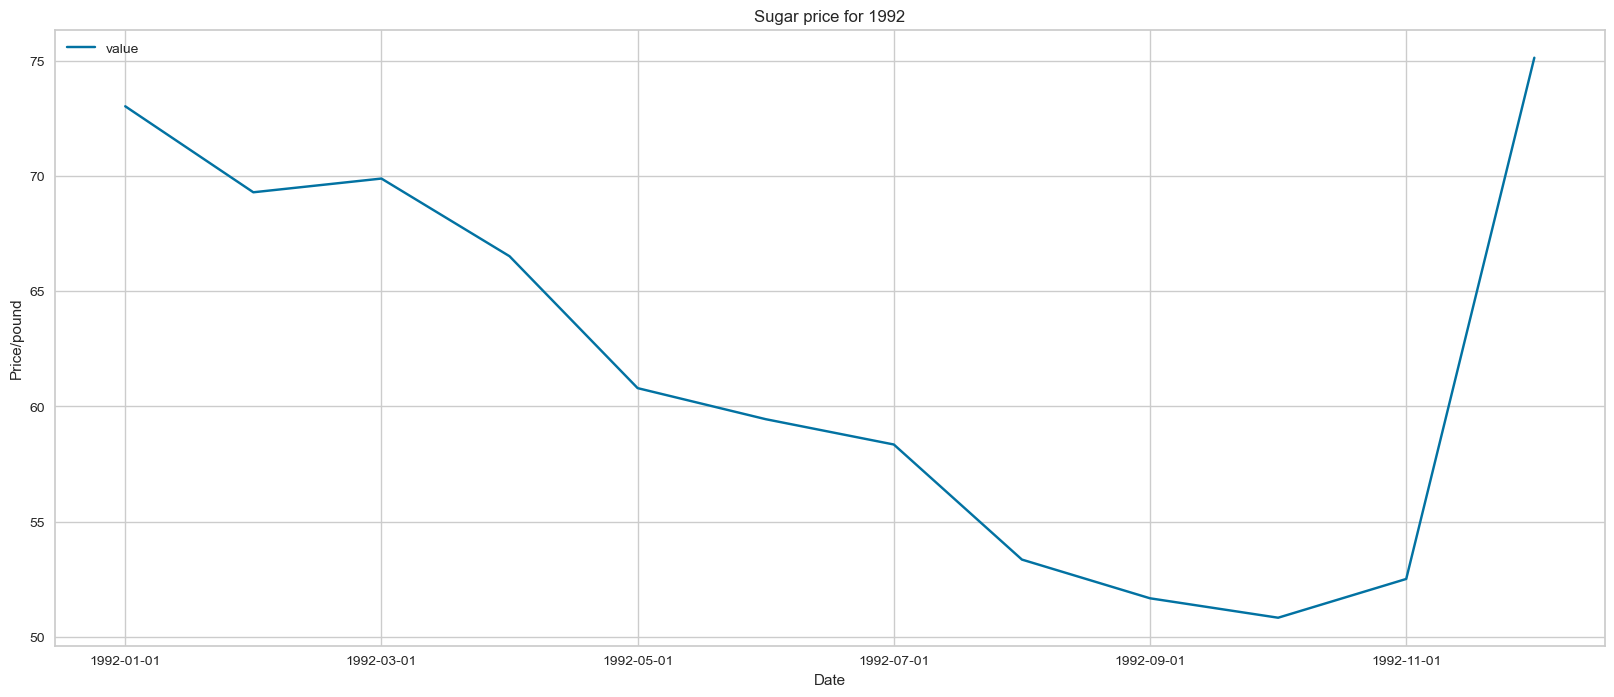

In [17]:
df.loc[(df.index >= '1992-01-01') & (df.index < '1993-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 1992')
plt.show()

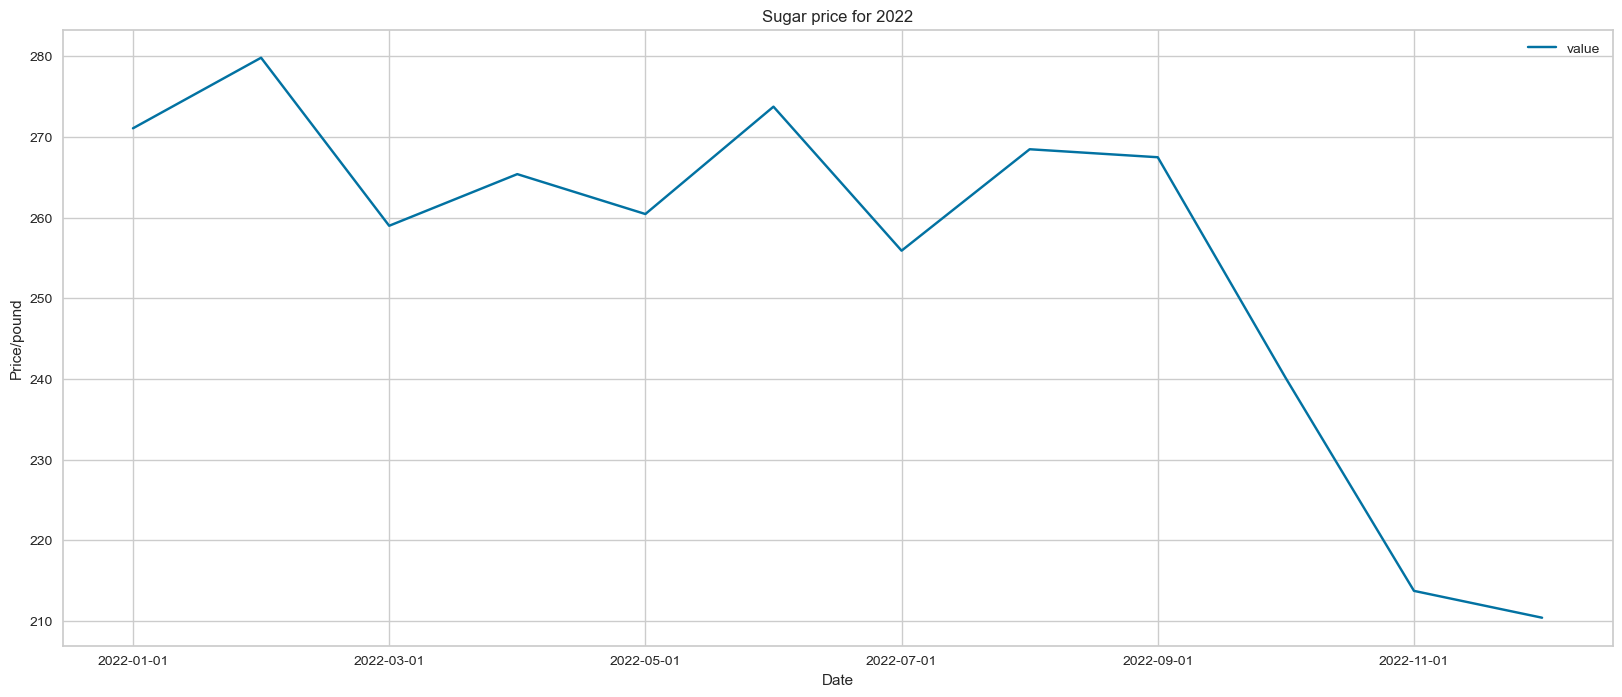

In [18]:
df.loc[(df.index >= '2022-01-01') & (df.index < '2023-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 2022')
plt.show()

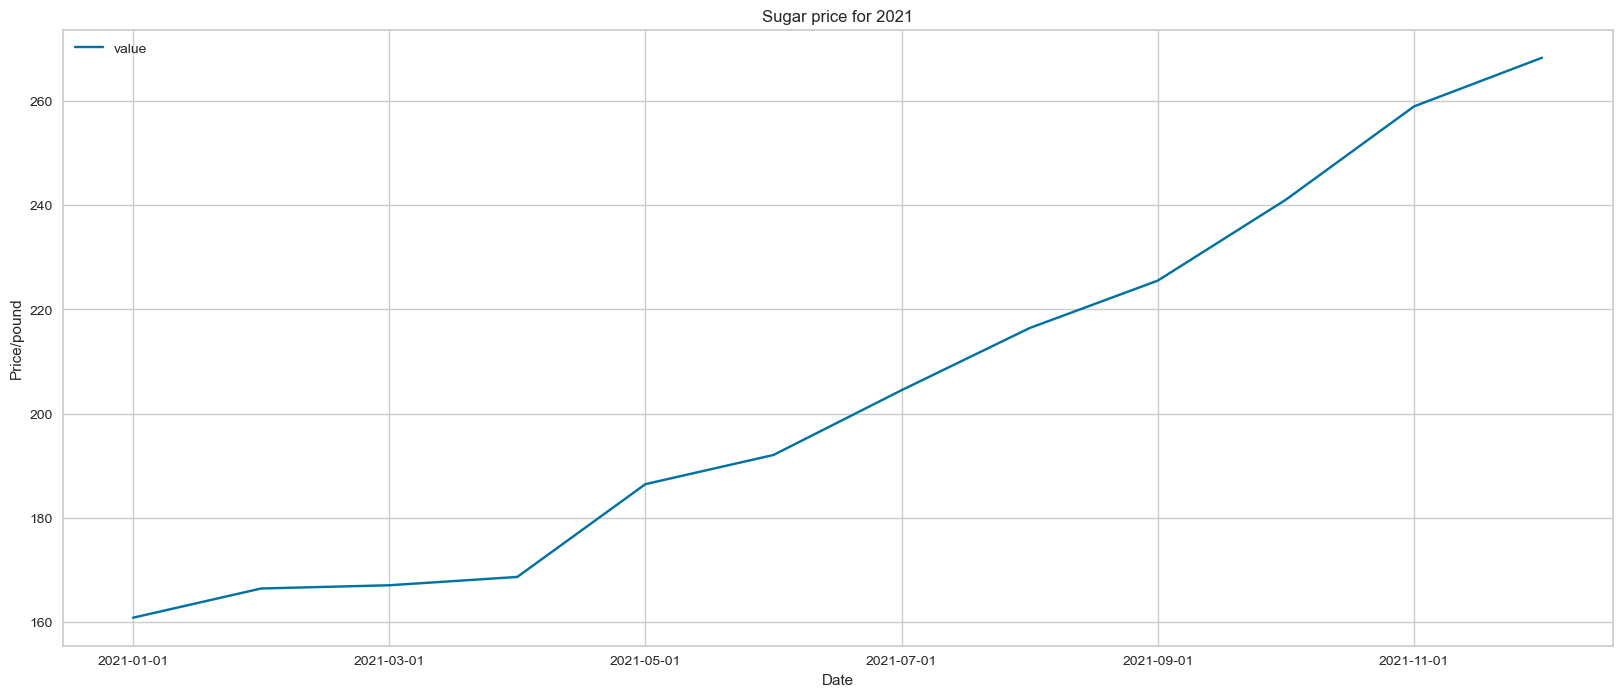

In [19]:
df.loc[(df.index >= '2021-01-01') & (df.index < '2022-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 2021')
plt.show()

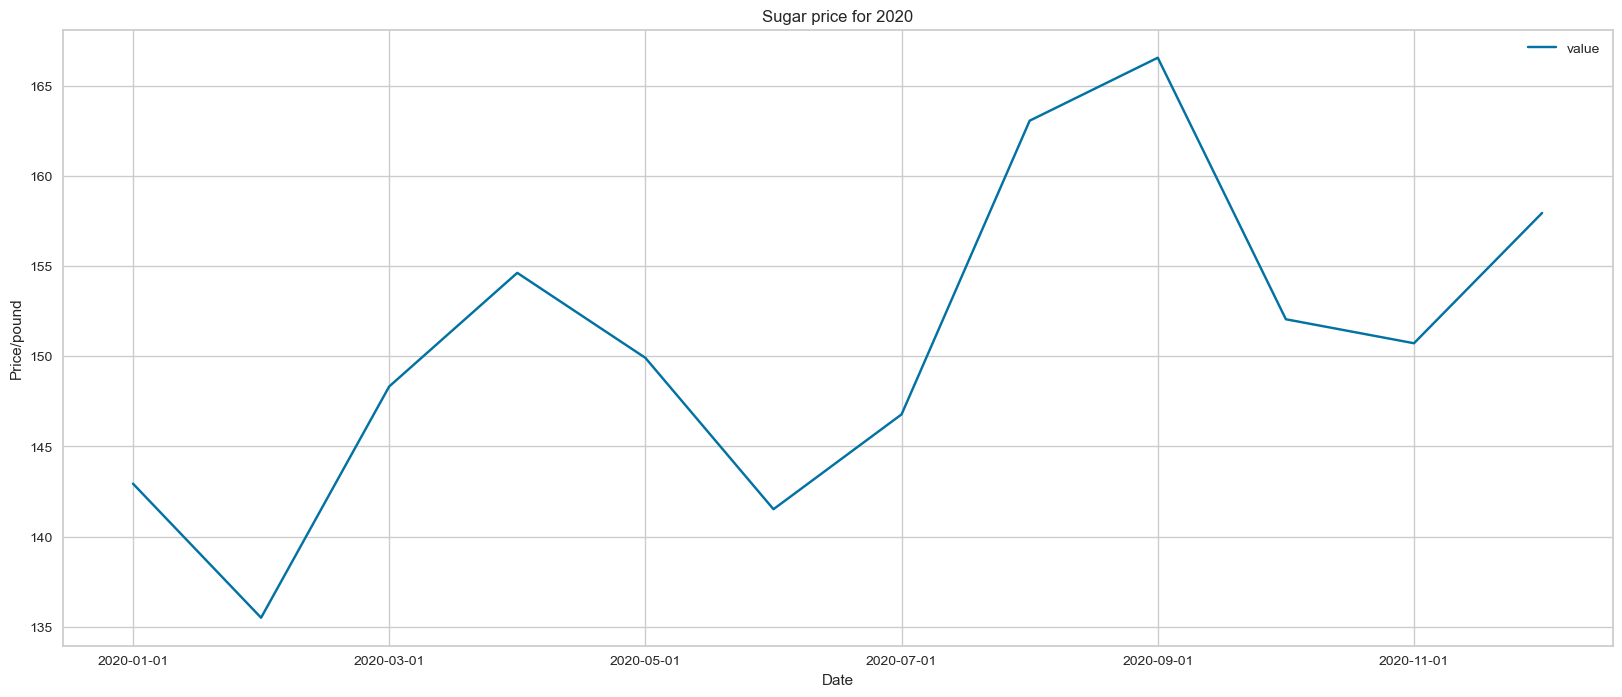

In [20]:
df.loc[(df.index >= '2020-01-01') & (df.index < '2021-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 2020')
plt.show()

The price os sugar is very variable, there are no apparent seasons or trends. The price has only increased by 5 units since 1990, with a highest recorded price of about 30. 

# 5. Creation of some features

Create some lag features (shift the dataframe values by 1,2,3,6,12 months), and we will use these values to predict future prices

In [21]:
lags = (1,2,3,6,12)

df = df.assign(**{f'{col} (t-{lag})':df[col].shift(lag) for lag in lags for col in df})

In [22]:
df.rename(columns={'value (t-1)': '1M_lag', 'value (t-2)': '2M_lag','value (t-3)': '3M_lag', 'value (t-6)': '6M_lag','value (t-12)': '1Y_lag'}, inplace=True)

In [23]:
print(df)

                 value      1M_lag      2M_lag      3M_lag      6M_lag  \
date                                                                     
1990-01-01   75.829987         NaN         NaN         NaN         NaN   
1990-02-01   84.010010   75.829987         NaN         NaN         NaN   
1990-03-01   93.959991   84.010010   75.829987         NaN         NaN   
1990-04-01   93.730011   93.959991   84.010010   75.829987         NaN   
1990-05-01   92.019989   93.730011   93.959991   84.010010         NaN   
...                ...         ...         ...         ...         ...   
2022-11-01  213.718182  240.082381  267.492273  268.483478  260.449545   
2022-12-01  210.388636  213.718182  240.082381  267.492273  273.763636   
2023-01-01  206.760000  210.388636  213.718182  240.082381  255.906667   
2023-02-01  229.506000  206.760000  210.388636  213.718182  268.483478   
2023-03-01  222.663913  229.506000  206.760000  210.388636  267.492273   

                1Y_lag  
date        

Worked as intended

# Train/Test split

In [24]:
df.dropna(axis=0, inplace=True)

In [25]:
print(len(df))

387


we have 387 values, split the data roughly 80:20, or into values before 2016 and values after&including 2017

In [26]:
train = df.loc[df.index < '2016-01-01']
test = df.loc[df.index >= '2017-01-01']

In [27]:
x_train = train.drop('value', axis=1)
y_train = train[['value']]

x_test = test.drop('value', axis=1)
y_test = test['value']

In [28]:
print(len(x_train) == len(y_train))
print(len(x_test) == len(y_test))

True
True


# Model tuning

In [29]:
def algorithm_optimisation(x_train, x_test, y_train, y_test, model, scoring_fit, param_grid):
    #Takes in pre-split data, model type, scoring to judge best parameters,
    #and a list of parameters to optimise for(These are tuning parameters for ML models)
    
    #Initiate the model with parameters
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, scoring=scoring_fit)
    
    #Fit the model with the training data and print the best parameters
    fitted_model = gs.fit(x_train, y_train)
    print(fitted_model.best_params_)
    
    
    #Initiate and fit a new model with the best parameters
    model = gs.best_estimator_
    model.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
    
    #Predict y-values
    y_predict = model.predict(x_test)
    
    
    #Find the mean square error, mean absolute error and r2 value and print
    mse_v = mse(y_test, y_predict)
    mae_v = mae(y_test, y_predict)
    r2_v = r2_score(y_test, y_predict)
    
    
    print("R-Squared: ", np.round(r2_v, 2))
    print("Mean Square Error: ", np.round(mse_v, 2))
    print("Mean Absolute Error: ", np.round(mae_v, 2))
    
    #Find the most importance features
    fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show()
    
    #Plot y_test vs y_predict
    plt.scatter(y_test, y_predict)
    plt.title('Y_test vs Y_predicted')
    plt.show()
    
    
    #Create dataframe of predicted vs actual values
    predict_actual = pd.DataFrame()
    predict_actual['Actual'] = y_test
    predict_actual['Prediction'] = y_predict
    print(predict_actual)
    
    #Find RMSE values for training and validation data, and plot them (Training and validation loss)
    results = model.evals_result()
    
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.axvline(21, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

{'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 50}
[0]	validation_0-rmse:72.40463	validation_1-rmse:94.55017
[49]	validation_0-rmse:4.54352	validation_1-rmse:12.55119
R-Squared:  0.93
Mean Square Error:  157.53
Mean Absolute Error:  9.85


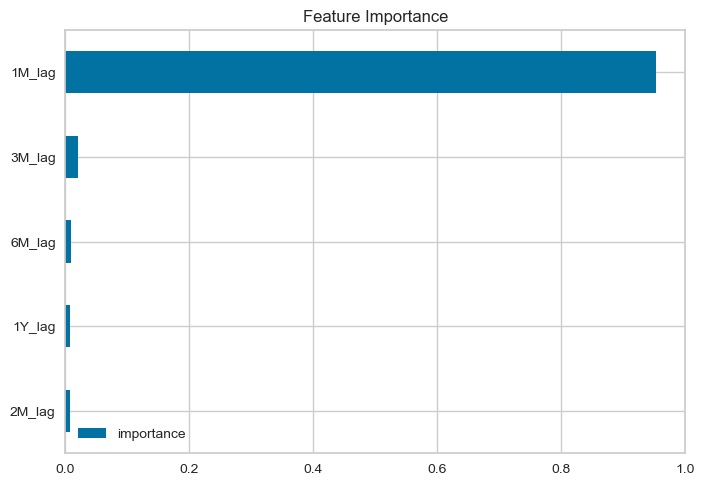

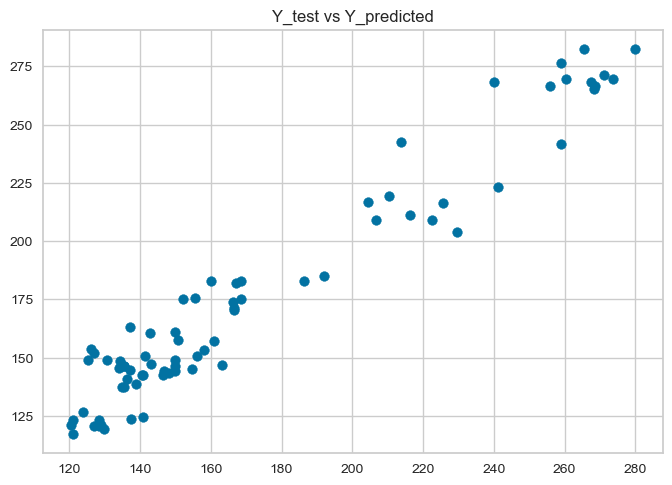

                Actual  Prediction
date                              
2017-01-01  168.612727  175.089661
2017-02-01  166.351000  173.954163
2017-03-01  160.150435  182.811478
2017-04-01  155.574000  175.619034
2017-05-01  150.000000  160.869888
...                ...         ...
2022-11-01  213.718182  242.601822
2022-12-01  210.388636  219.156174
2023-01-01  206.760000  209.137131
2023-02-01  229.506000  204.041702
2023-03-01  222.663913  209.186707

[75 rows x 2 columns]


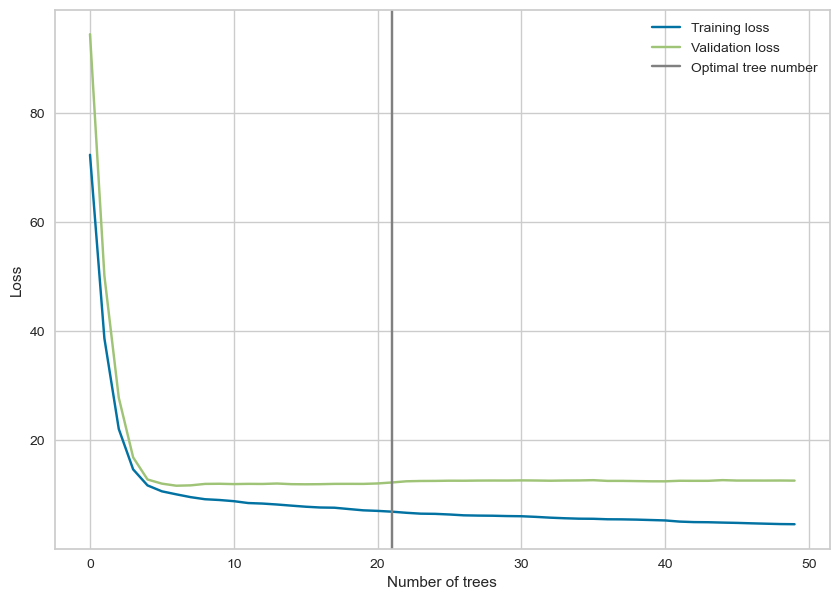

In [30]:
#Intiate the model
model = xgb.XGBRegressor()


#Parameters to change - increasing the learning rate & estimators step will increase the speed, but possibly underfit
learning_rate= np.arange(0, 1, 0.5)
depth = range(1,10,1)
estimators = range(50, 450, 100)


#Set up the parameter grid for tuning
param_grid = {
    'learning_rate': learning_rate, 'booster': ['gbtree'], 'max_depth': depth, 'n_estimators' : estimators}


#Run the algorith function
algorithm_optimisation(x_train, x_test, y_train, y_test, model, 'neg_mean_squared_error', param_grid)

{'booster': 'gblinear', 'learning_rate': 0.5, 'n_estimators': 350}
[0]	validation_0-rmse:117.54672	validation_1-rmse:129.05107
[100]	validation_0-rmse:13.38529	validation_1-rmse:11.34107
[200]	validation_0-rmse:12.22395	validation_1-rmse:10.63464
[300]	validation_0-rmse:11.62459	validation_1-rmse:10.34429
[349]	validation_0-rmse:11.43475	validation_1-rmse:10.25053
R-Squared:  0.96
Mean Square Error:  105.07
Mean Absolute Error:  7.86


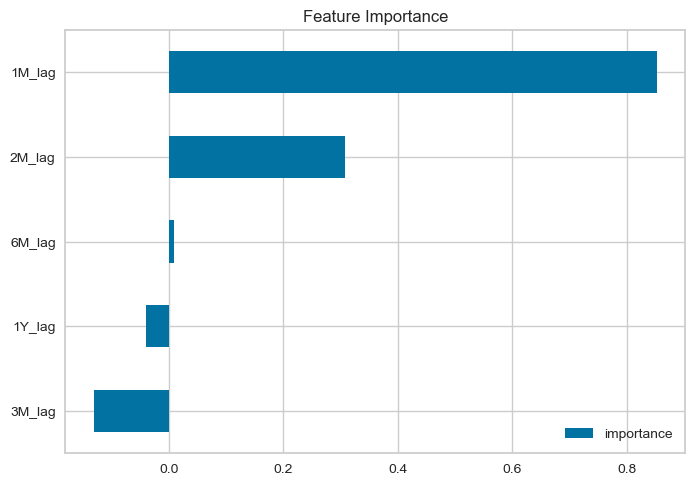

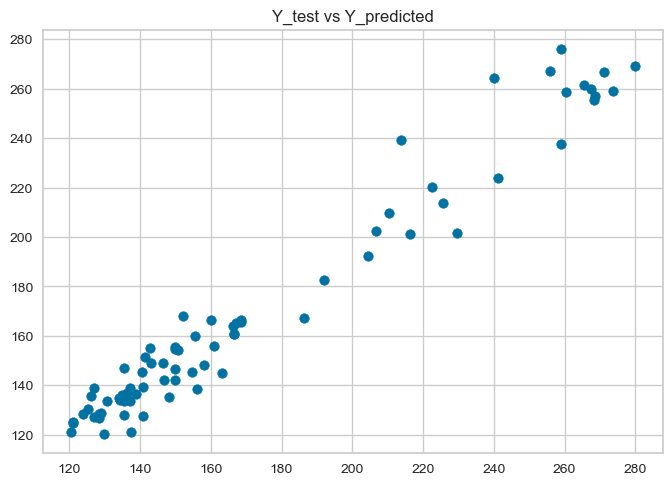

                Actual  Prediction
date                              
2017-01-01  168.612727  165.623276
2017-02-01  166.351000  163.836578
2017-03-01  160.150435  166.514557
2017-04-01  155.574000  160.080521
2017-05-01  150.000000  154.807556
...                ...         ...
2022-11-01  213.718182  239.400986
2022-12-01  210.388636  209.687744
2023-01-01  206.760000  202.374115
2023-02-01  229.506000  201.519806
2023-03-01  222.663913  220.195068

[75 rows x 2 columns]


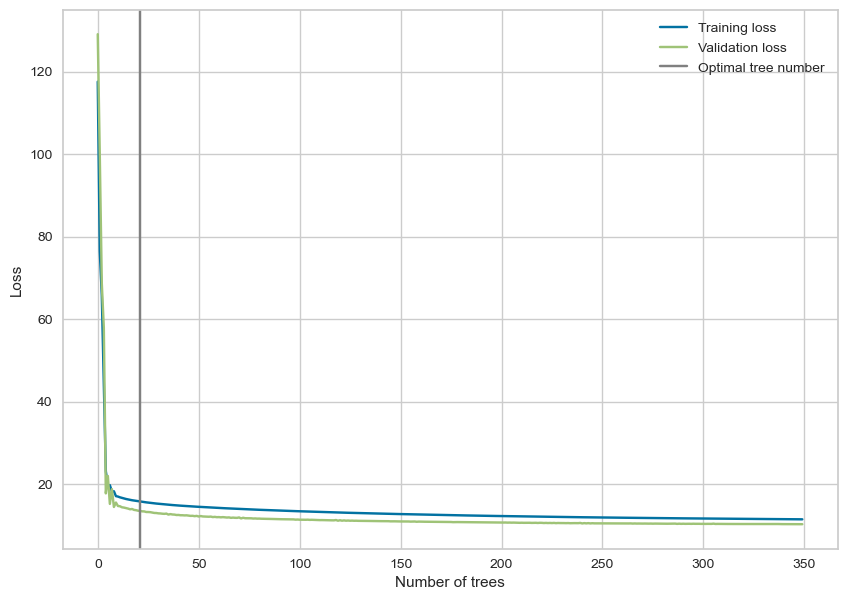

In [31]:
model = xgb.XGBRegressor()

learning_rate= np.arange(0, 1, 0.5)
estimators = range(50, 450, 100)



param_grid = {
    'learning_rate': learning_rate, 'booster': ['gblinear'], 'n_estimators' : estimators}

#Run the algorith function
algorithm_optimisation(x_train, x_test, y_train, y_test, model, 'neg_mean_squared_error', param_grid)

Assess the different models and decide on which one to take further

# Future Predictions

### Create a new df with all the values and retrain the model

In [32]:
df_fut = df

In [33]:
df_fut.dropna(axis=0, inplace=True)

In [34]:
x_train = df_fut.drop('value', axis=1)
y_train = df_fut[['value']]

x_test = df_fut.drop('value', axis=1)
y_test = df_fut['value']

In [35]:
def model_save(x_train, x_test, y_train, y_test, model, scoring_fit, param_grid):
    #Takes in pre-split data, model type, scoring to judge best parameters,
    #and a list of parameters to optimise for(These are tuning parameters for ML models)
    
    #Initiate the model with parameters
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, scoring=scoring_fit)
    
    #Fit the model with the training data and print the best parameters
    fitted_model = gs.fit(x_train, y_train)
    print(fitted_model.best_params_)
    
    
    #Initiate and fit a new model with the best parameters
    model = gs.best_estimator_
    model.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
    
    #Predict y-values
    y_predict = model.predict(x_test)
    
    
    mse_v = mse(y_test, y_predict)
    mae_v = mae(y_test, y_predict)
    r2_v = r2_score(y_test, y_predict)
    
    
    print("R-Squared: ", np.round(r2_v, 2))
    print("Mean Square Error: ", np.round(mse_v, 2))
    print("Mean Absolute Error: ", np.round(mae_v, 2))
    
    
    
    plt.scatter(y_test, y_predict)
    plt.title('Y_test vs Y_predicted')
    plt.show()
    
          
    predict_actual = pd.DataFrame()
    predict_actual['Actual'] = y_test
    predict_actual['Prediction'] = y_predict
    print(predict_actual)

    results = model.evals_result()
    
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.axvline(21, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
    #Perform the same model optimisation but this time save the model
    model.save_model('model_coffee.json')

{'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 100}
[0]	validation_0-rmse:76.95029	validation_1-rmse:76.95029
[99]	validation_0-rmse:3.54847	validation_1-rmse:3.54847
R-Squared:  1.0
Mean Square Error:  12.59
Mean Absolute Error:  2.73


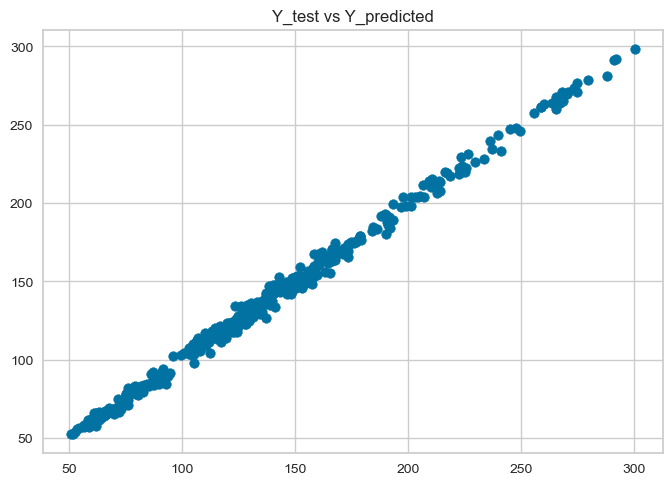

                Actual  Prediction
date                              
1991-01-01   86.320007   91.052620
1991-02-01   89.570007   84.761978
1991-03-01   93.720001   89.791702
1991-04-01   92.269989   90.478119
1991-05-01   87.589996   89.791702
...                ...         ...
2022-11-01  213.718182  213.949463
2022-12-01  210.388636  210.084686
2023-01-01  206.760000  211.580124
2023-02-01  229.506000  226.059555
2023-03-01  222.663913  222.671082

[387 rows x 2 columns]


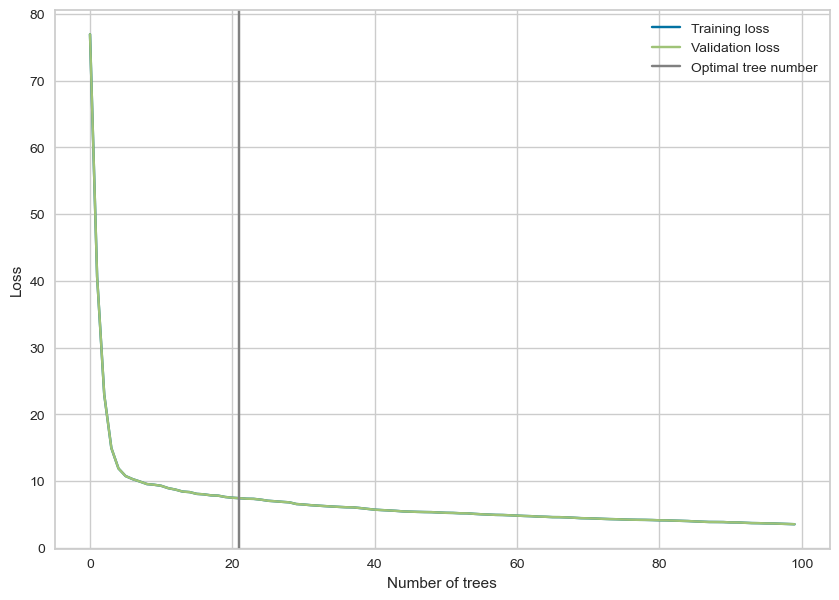

In [36]:
model = xgb.XGBRegressor()

learning_rate= np.arange(0, 1, 0.5)
depth = range(1,10,1)
estimators = range(50, 500, 50)



param_grid = {
    'learning_rate': learning_rate, 'booster': ['gbtree'], 'max_depth': depth, 'n_estimators' : estimators}

#Run the algorith function
model_save(x_train, x_test, y_train, y_test, model, 'neg_mean_squared_error', param_grid)

Now we have the model trained, reinitiate the model

In [37]:
model_predi = xgb.XGBRegressor()
model_predi.load_model('model_coffee.json')

Make a new df with the values we want to predict

Find the latest date in the df, add 3 months. Then make a new dataframe with the new dates. Concat the old dataframe (only values column) and the new dates

### Dateframe preparation

In [38]:
latest_date = df_fut.index.max()
start_date_future = pd.to_datetime(latest_date) + relativedelta(months=1)

In [39]:
future = pd.date_range(start_date_future, periods=3, freq='MS').strftime('%Y-%m-%d')
future_df = pd.DataFrame(index=future)

In [40]:
old_df = df['value']

In [41]:
df_and_future = pd.concat([old_df, future_df])

### Create new lag features

In [42]:
lags = (1,2,3,6,12)

df_and_future = df_and_future.assign(**{f'{col} (t-{lag})':df_and_future[col].shift(lag) for lag in lags for col in df_and_future})

df_and_future.rename(columns={'0 (t-1)': '1M_lag', '0 (t-2)': '2M_lag','0 (t-3)': '3M_lag', '0 (t-6)': '6M_lag','0 (t-12)': '1Y_lag'}, inplace=True)

df_and_future = df_and_future[12::]

### Predict the next three months

In [43]:
predict_next_month = df_and_future[:-2].copy()

In [44]:
features = ['1M_lag', '2M_lag', '3M_lag', '6M_lag', '1Y_lag']

In [45]:
predict_next_month['pred'] = model_predi.predict(predict_next_month[features])

month_1_predic = predict_next_month.iloc[-1]['pred']

In [46]:
df_and_future.iloc[[-2],[1]] = month_1_predic

predict_month_two = df_and_future[:-1].copy()

In [47]:
predict_month_two['pred'] = model_predi.predict(predict_month_two[features])

month_2_predic = predict_month_two.iloc[-1]['pred']

In [48]:
df_and_future.iloc[[-1],[1]] = month_2_predic
df_and_future.iloc[[-1],[2]] = month_1_predic

predict_month_three = df_and_future[::].copy()

In [49]:
predict_month_three['pred'] = model_predi.predict(predict_month_three[features])

month_3_predic = predict_month_three.iloc[-1]['pred']

In [50]:
print(month_1_predic, month_2_predic, month_3_predic)

209.57493591308594 220.87034606933594 210.32481384277344
